<a href="https://colab.research.google.com/github/ykenkou001/diveintocode-ml/blob/master/Sprint_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 【問題1】機械翻訳の実行とコードリーディング

In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
!unzip /content/drive/'My Drive/Colab Notebooks/Sprint_24'/pytorch-tutorial/tutorials/03-advanced/image_captioning/fra-eng.zip

Archive:  /content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [0]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 10 # Number of epochs to train for.ee
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set() #集合set関数で重複を避けている。
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') #改行区切りでテキストファイルを読み込む

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t') #input_text, target_textそれぞれににテキストファイルをタブ区切りで格納
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    # Sequenceの始まりをタブとし、終わりを改行とする。
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text) #input_textsリストに取り出したinput_text（単語）を代入
    target_texts.append(target_text) #target_textsリストに取り出したtarget_text（単語）を代入
    # input_text, target_textそれぞれ一文字づつ取り出し、input_charactersリスト、
    # target_charactersリストに格納する
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)# addは処理が遅いから処理する回数を減らすため、ユニーク値を絞る。
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print(input_characters)
            
input_characters = sorted(list(input_characters))#文字を格納したリストをソートする
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)# encoder_token数を抽出
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])# encoder, decoderの長さを定義する。
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

#input, targetそれぞれindexを振る。
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#encoder、decoderそれぞれの要素"0"の空配列を作る。
#shape：(text数、encoder,decoderそれぞれの長さ、それぞれのtoken数)
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
# 入力sequenceを定義し、それを実行する。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
#encoderをLSTMネットワークで定義する。
encoder = LSTM(latent_dim, return_state=True)
#encoderの出力を変数に格納
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
# 「encoder_outputs」を破棄し、状態(states)のみを保持します。
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
#完全な出力シーケンスを返すようにデコーダを設定し、内部状態も返すようにします。
#トレーニングモデルではstates（状態）を使用しませんが、推論では使用します。

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# `encoder_input_data`と` decoder_input_data`を `decoder_target_data`に変えるモデルを定義する
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states
#next：推論モード（サンプリング）。 
#ドリルを次に示します。
#1）入力をエンコードし、初期デコーダー状態を取得します
#2）この初期状態と「シーケンスの開始」トークンをターゲットとしてデコーダーの1ステップを実行します。 
#出力は次のターゲットトークンになります
#3）現在のターゲットトークンと現在の状態で繰り返します

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
#シーケンスをデコードして読みやすいものに戻すための
#逆ルックアップトークンインデックス
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    # 入力を状態ベクトルとしてエンコードします。
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    # 長さ1の空のターゲットシーケンスを生成します。
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    # ターゲットシーケンスの最初の文字に開始文字を入力します。
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    # シーケンスのバッチのサンプリングループ
    #（簡単にするために、ここではサイズ1のバッチを想定しています）。
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        #終了条件：最大長をヒットするか
        #停止文字を見つけます。
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        # ターゲットシーケンス（長さ1）を更新します。
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    #デコードを試すために、1つのシーケンス（トレーニングセットの一部）を取得します。
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

{'b', 'w', 'B', 'W', 'p', 'O', 'd', 'z', 'P', 'h', '?', 'T', '!', 'i', ' ', 'U', '3', '$', 't', 'g', 'k', 'f', 'D', '1', '5', 'q', ':', '.', '&', 'Q', 'n', 'e', 'v', 's', 'H', 'o', '0', '2', 'c', 'F', 'I', 'j', '-', '9', 'L', "'", 'y', 'm', 'R', 'A', ',', '7', 'u', 'C', 'l', '6', 'x', 'r', 'Y', 'G', 'a', 'K', 'S', 'V', '8', 'M', 'N', 'E', 'J', '%'}
Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 24s 3ms/step - loss: 1.1870 - acc: 0.7245 - val_loss: 1.1150 - val_acc: 0.7013
Epoch 2/10
8000/8000 [==============================] - 18s 2ms/step - loss: 0.8457 - acc: 0.7722 - val_loss: 1.0012 - val_acc: 0.7529
Epoch 3/10
8000/8000 [==============================] - 17s 2ms/st

## **【解答】**
・62行目：テキストファイルを読み込み用で開き、改行区切りで読み込む <font color="Red"></font>  
・65～80行目：読み込んだテキストファイルからinput, targetに分けて、1行づつ単語を取り出し、さらに一文字づつに分解し、リストに格納している。  
・82～87行目：一文字を格納したリストを文字列でソートし、token数を抽出し、encoder、decoderの長さを定義している。    
・127～135行目：encoderのネットワークを定義する。  
・137～149行目：decoderのネットワークを定義する。  
・151～163行目：モデルを定義し、学習する。  
・168～203行目：再び（？）,encoder、decoderのmodelを定義している。（推論モード？）  
・206～249行目：英語→フランス語に変換（推定）する関数を定義している。  
・252～260行目：テストデータ（100個）で推定結果を出力している。  

***上記コード中にコードリーディングした注釈入れました。**


# 【問題2】イメージキャプショニングの学習済みモデルの実行

In [0]:
cd /content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
!unzip /content/drive/'My Drive/Colab Notebooks'/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip -d models

Archive:  /content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip
  inflating: models/encoder-5-3000.pkl  
  inflating: models/decoder-5-3000.pkl  


In [0]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


In [0]:
mv dog.4.jpg /content/drive/'My Drive/Colab Notebooks'/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png

mv: cannot stat 'dog.4.jpg': No such file or directory


In [0]:
mv /content/dog.4.jpg /content/drive/'My Drive/Colab Notebooks'/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png

### 自分で用意した画像で実行

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

In [0]:
cd /content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
dog_img = Image.open('/content/drive/My Drive/Colab Notebooks/Sprint_24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/dog.4.jpg')
        
#サイズを揃える   
dog_img = dog_img.resize((224, 224))
        
#PIL.Image. Imageからnumpy配列へ
dog_img = np.array(dog_img)
        
#正規化
dog_img = dog_img / 255.0
        
#axisの追加
dog_img = dog_img.reshape((224, 224, 3))
#dog_img_array = np.concatenate([dog_img_array, dog_img], axis=0)
        

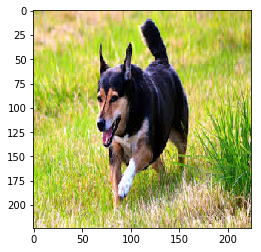

In [0]:
plt.imshow(dog_img)

In [0]:
!python sample.py --image='png/dog.4.jpg'

<start> a dog is standing in a field with a frisbee . <end>


In [0]:
rm -r /content/drive/'My Drive/Colab Notebooks'/Sprint_24/coco

# 【問題3】Kerasで動かしたい場合はどうするかを調査  
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。  

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

・ONNX（オニキス）フォーマットを使用して学習させたモデルをkerasを使えるようにする(onnx2keras) 。  
・または、__MMdnn__を使用し、フレームワーク間でモデルを相互変換する。  
・__channel_first(pytorch)__から__channe_last(keras)__に変換する。  
（参考：(https://qiita.com/lain21/items/9f9f9707ebad4bbc627d))


# 【問題4】（アドバンス課題）コードリーディングと書き換え

### やっていません。

# 【問題5】（アドバンス課題）発展的調査

### やっていません。